In [1]:
%matplotlib inline

In [2]:
import numpy as np
from qreservoirpy import QReservoir, Layers, utilities
from qiskit.circuit.library.standard_gates import HGate, SGate, CXGate


In [3]:
n_qubits = 50
shots = 10000
circop = utilities.random_circuit(n_qubits, gates=[
    HGate, SGate, CXGate
], depth=60)
op = circop.to_gate(label='RES')
# circop.draw('mpl')


In [4]:
target = [0, 0, 0, 1] * 30
def build_method(circ, timestep, operator, encoder):
    circ.append(operator,circ.qubits)
    for i in range(4):
        circ.measure(i)
        circ.initialize(encoder[timestep], [i])
    return circ

res = QReservoir(
    qubits=n_qubits, 
    layers=[
        Layers.H(),
        Layers.Timeseries(build_method=build_method),
    ], 
    operator=op, 
    encoder={
        0: '0',
        1: '1',  
    })
states = res.run(target, shots=shots, transpile=True, simulator='aer_simulator_stabilizer')
# res.circuit.draw('mpl')


Started running


100%|██████████| 120/120 [02:28<00:00,  1.23s/it, running=Simulating]


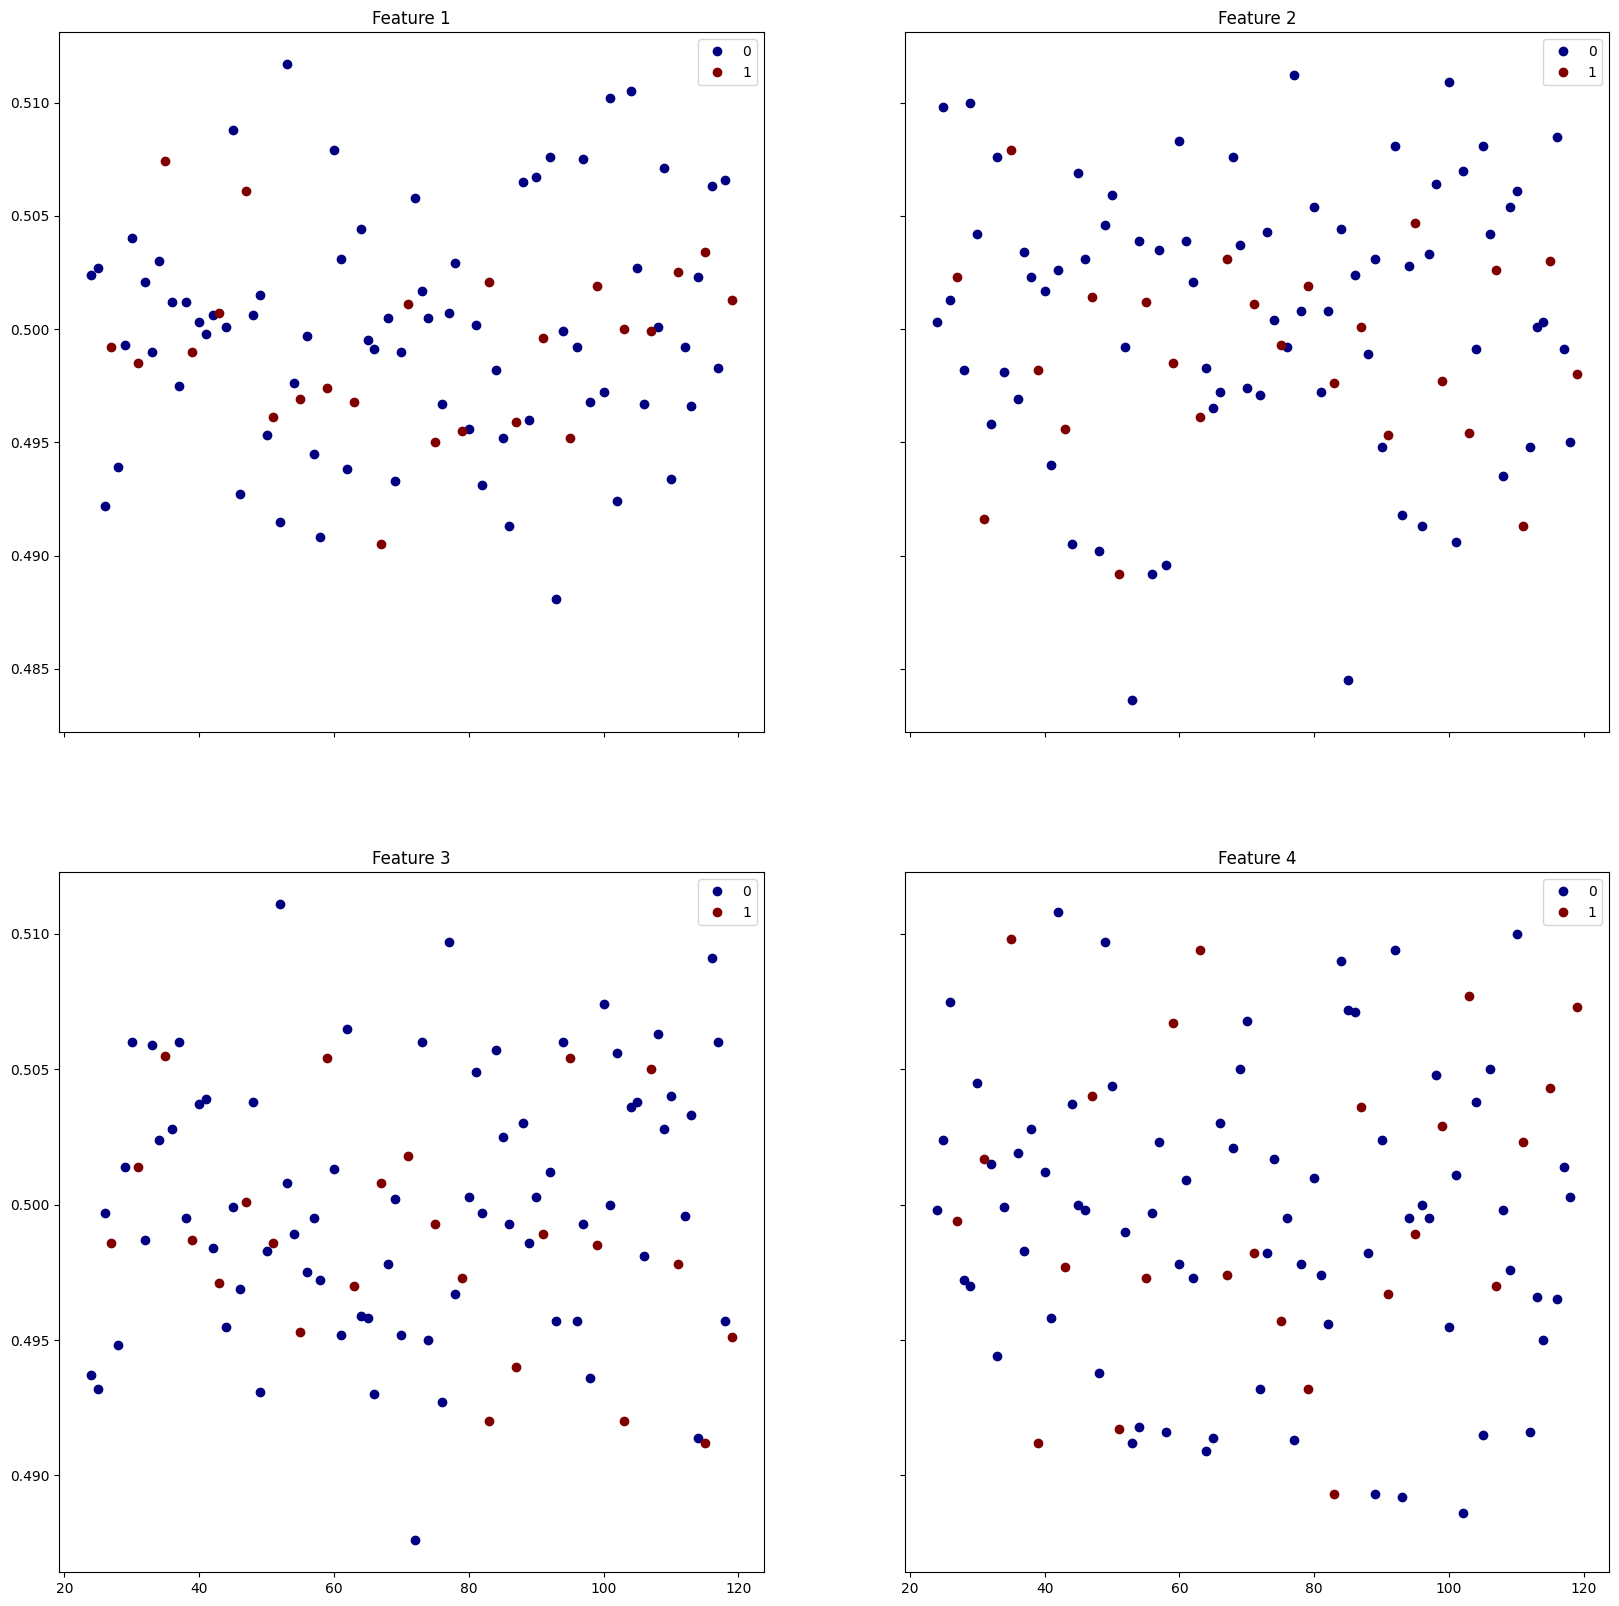

In [5]:
fig ,axes = utilities.result_plotter(states, target, warmup=0.2)